In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

# Challenge: Make Your Own Multivariate Regression Model

Using the UCR crime dataset, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction vs. understanding mechanisms, so focus on creating a model that explains a lot of variance.


In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

pd.options.display.float_format = '{:,.0f}'.format

crime_df = pd.read_excel('./NY_crimes.xls', header=4)
crime_df.head()

City  Population  Violent\ncrime  \
0             Adams Village       1,861               0   
1  Addison Town and Village       2,577               3   
2             Akron Village       2,846               3   
3                    Albany      97,956             791   
4            Albion Village       6,388              23   

   Murder and\nnonnegligent\nmanslaughter  Rape\n(revised\ndefinition)1  \
0                                       0                           nan   
1                                       0                           nan   
2                                       0                           nan   
3                                       8                           nan   
4                                       0                           nan   

   Rape\n(legacy\ndefinition)2  Robbery  Aggravated\nassault  Property\ncrime  \
0                            0        0                    0               12   
1                            0        0                    3               24   
2                            0        0                    3               16   
3                           30      227                  526            4,090   
4                            3        4                   16              223   

   Burglary  Larceny-\ntheft  Motor\nvehicle\ntheft  Arson3  
0         2               10                      0       0  
1         3               20                      1       0  
2         1               15                      0       0  
3       705            3,243                    142     nan  
4        53              165                      5     nan

In [3]:
crime_df['Population Sq.'] = crime_df['Population'] ** 2
crime_df['Robbery Categ'] = np.where(crime_df['Robbery'] > 0, 1, 0)
crime_df['Murder Categ'] = np.where(crime_df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)

crime_df = crime_df.drop(['Rape\n(revised\ndefinition)1', 'Motor\nvehicle\ntheft', 'Larceny-\ntheft', 'Burglary', 'Property\ncrime', 'Arson3'], axis=1)
crime_df = crime_df[pd.notnull(crime_df['Population'])]
crime_df.rename(columns = {'Violent\ncrime': 'Violent crime', 'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Rape\n(legacy\ndefinition)2':'Rape', 'Aggravated\nassault': 'Assault'}, inplace = True)

crime_df['Violent crimes add up'] = crime_df['Violent crime'] == crime_df['Murder'] + crime_df['Rape'] + crime_df['Robbery'] +crime_df['Assault']
crime_df['More crimes than people'] = crime_df['Violent crime'] > crime_df['Population']

print('{} rows where violent crimes did not add up'.format(len(crime_df) - np.sum(crime_df['Violent crimes add up'])))
print('{} rows where more crimes than people'.format(np.sum(crime_df['More crimes than people'])))

crime_df = crime_df.drop(['Violent crimes add up', 'More crimes than people'], axis=1)
crime_df.head()

0 rows where violent crimes did not add up
0 rows where more crimes than people


City  Population  Violent crime  Murder  Rape  Robbery  \
0             Adams Village       1,861              0       0     0        0   
1  Addison Town and Village       2,577              3       0     0        0   
2             Akron Village       2,846              3       0     0        0   
3                    Albany      97,956            791       8    30      227   
4            Albion Village       6,388             23       0     3        4   

   Assault  Population Sq.  Robbery Categ  Murder Categ  
0        0       3,463,321              0             0  
1        3       6,640,929              0             0  
2        3       8,099,716              0             0  
3      526   9,595,377,936              1             1  
4       16      40,806,544              1             0

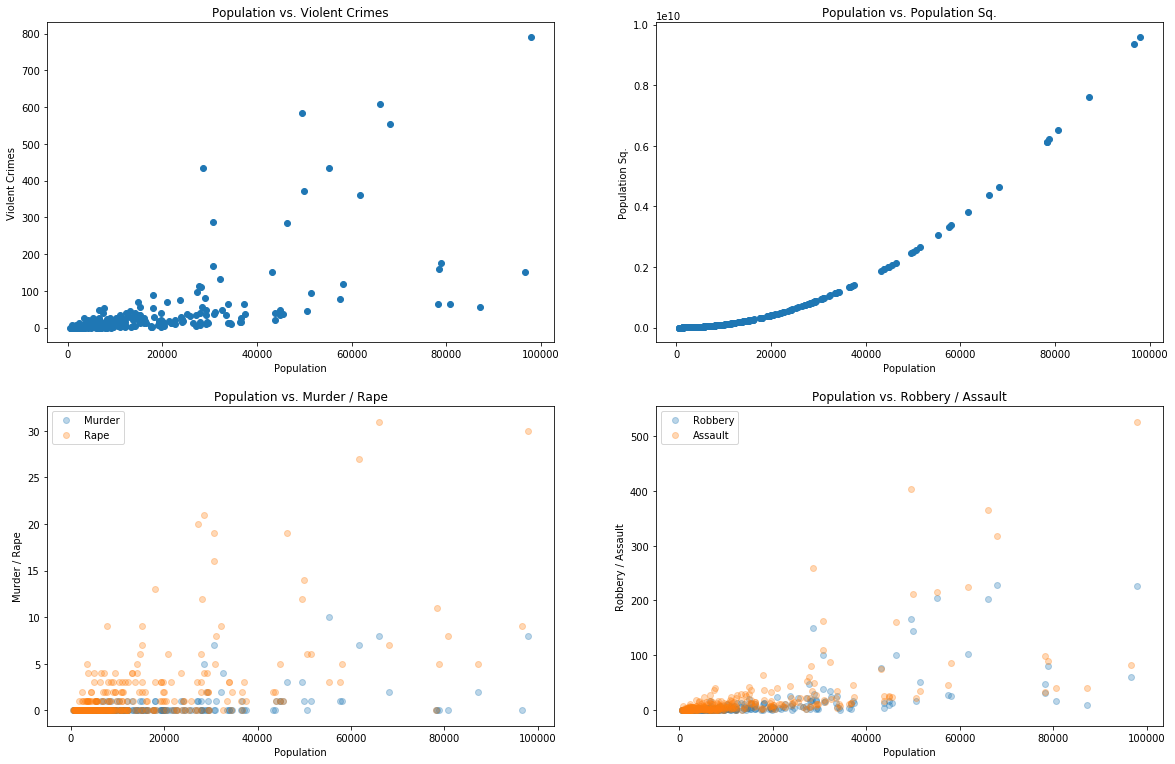

In [4]:
cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

def display_relevant_plots(df):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 2, 1)
    plt.scatter(df['Population'], df['Violent crime'])
    plt.xlabel('Population')
    plt.ylabel('Violent Crimes')
    plt.title('Population vs. Violent Crimes')

    plt.subplot(3, 2, 2)
    plt.scatter(df['Population'], df['Population Sq.'])
    plt.xlabel('Population')
    plt.ylabel('Population Sq.')
    plt.title('Population vs. Population Sq.')

    plt.subplot(3, 2, 3)
    plt.scatter(df['Population'], df['Murder'], alpha=0.3)
    plt.scatter(df['Population'], df['Rape'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Murder / Rape')
    plt.title('Population vs. Murder / Rape')
    plt.legend(['Murder', 'Rape'])

    plt.subplot(3, 2, 4)
    plt.scatter(df['Population'], df['Robbery'], alpha=0.3)
    plt.scatter(df['Population'], df['Assault'], alpha=0.3)
    plt.xlabel('Population')
    plt.ylabel('Robbery / Assault')
    plt.title('Population vs. Robbery / Assault')
    plt.legend(['Robbery', 'Assault'])

    plt.show()

display_relevant_plots(cities_under_outlier_cutoff)

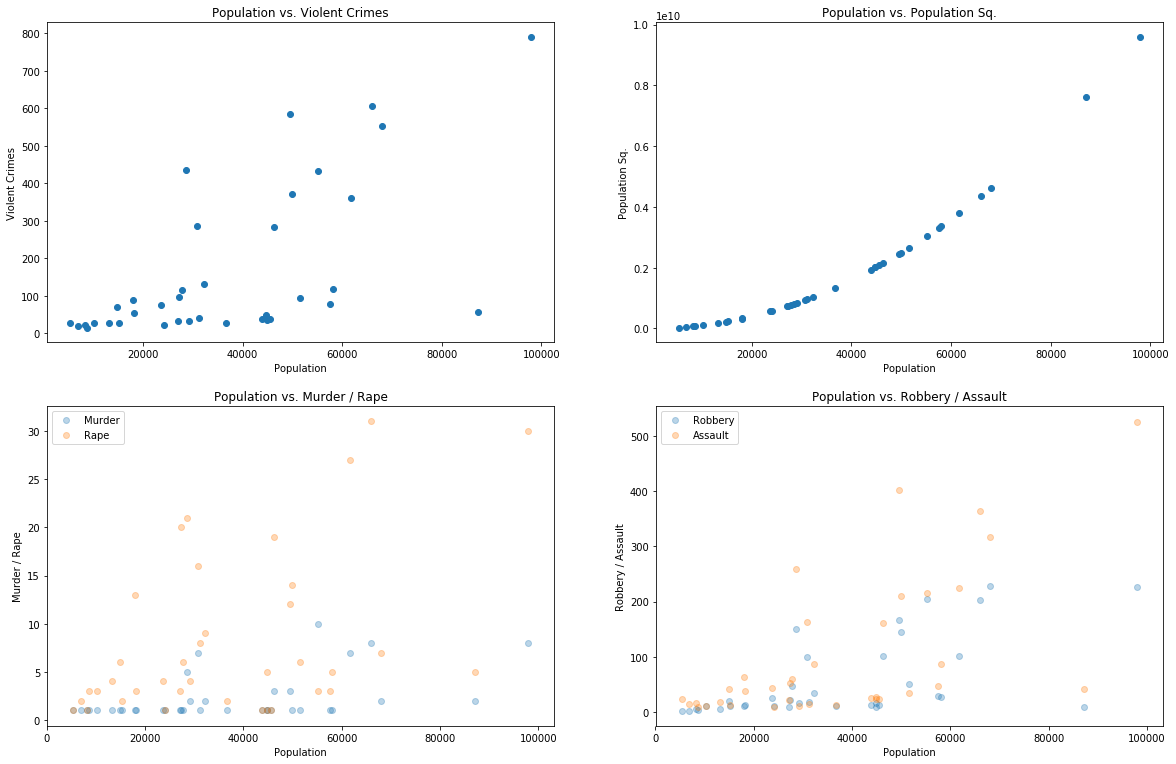

In [5]:
crime_df = crime_df[(crime_df['Violent crime'] > 0) & (crime_df['Murder'] > 0) & (crime_df['Rape'] > 0) & (crime_df['Robbery'] > 0) & (crime_df['Assault'] > 0)]
new_cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

display_relevant_plots(new_cities_under_outlier_cutoff)

## Model

In [17]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_df['Violent crime'].values.reshape(-1, 1)
X = crime_df[['Population', 'Robbery Categ', 'Murder Categ', 'Robbery', 'Murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 8.09009494e-04 -3.99680289e-14  0.00000000e+00  2.45312317e+00
  -4.30975536e+00]]

Intercept: 
 [7.10406316]

R-squared:
0.9999389543502526


## Feature Engineering and Selection Process